In [1]:
import sys
sys.path.append("..\\") # parent directory
from AQUA_general import AQUA
from batchAQUA_general import batchAQUA
from stimulus import *
from plotting_functions import *
from phase_response import *


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functions import *

In [2]:
RS = {'name': 'RS', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
    'a': 0.03, 'b': 5, 'c': -50, 'd': 100, 'e': 0., 'f': 0.0, 'tau': 0.0}
#'e': 0.2, 'f': 150.0, 'tau': 2.0

IB = {'name': 'IB', 'C': 150, 'k': 1.2, 'v_r': -75, 'v_t': -45, 'v_peak': 50,
     'a': 0.01, 'b': 5, 'c': -56, 'd': 130, 'e': 0.0, 'f': 0.0, 'tau': 0.0}

FS = {'name': 'FS', 'C': 20, 'k': 1, 'v_r': -55, 'v_t': -40, 'v_peak': 25,
     'a': 0.2, 'b': -2, 'c': -45, 'd': 0, 'e': 0.0, 'f': 0.0, 'tau': 0.0}

100%|██████████| 199999/199999 [00:33<00:00, 6056.97it/s]


(3, 200000)


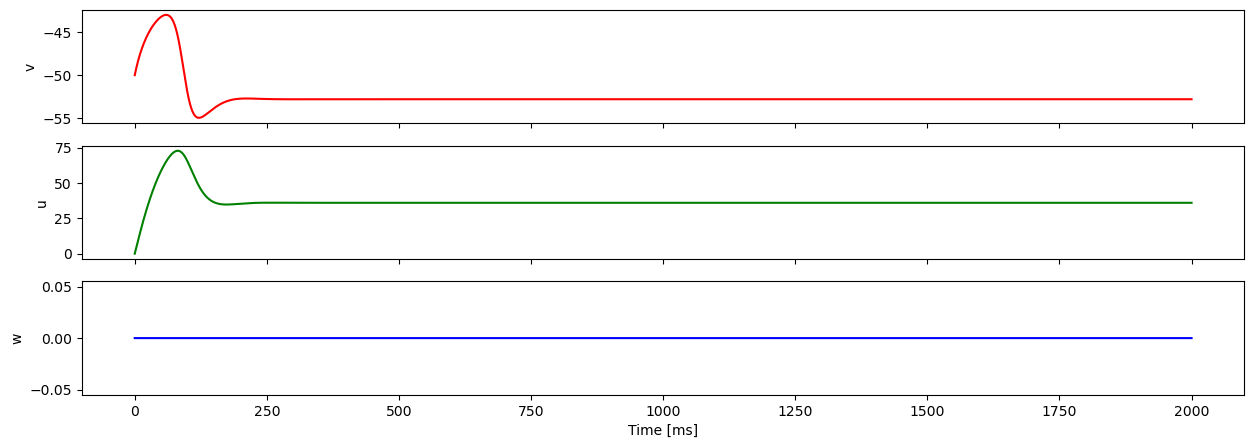

[100.43731778]


100%|██████████| 49999/49999 [00:08<00:00, 5783.58it/s]


In [13]:
T = 2
dt = 0.01
N_iter = int(1000*T/dt)

# number of neurons
N_neurons = 600

# frequencies to sample
f_range = np.linspace(1, 200, N_neurons)

threshold, x_ini = find_threshold(RS, np.linspace(50, 400, 50), T, dt)
print(threshold)
x_start = np.full((N_neurons, 3), x_ini)
t_start = np.zeros(N_neurons)

# Setup batch of neurons
params_list = []
for n in range(N_neurons):
    params_list.append(RS)

batch = batchAQUA(params_list)
batch.Initialise(x_start, t_start)


# Setup current pulses
N_pulses = 2
delay = 500 # ms
pulse_duration = 5  # ms
pulse1_end = delay + pulse_duration - dt # ms, from settings above

# minimum pulse height and the time between the end of the pulse and the spike.
pulse_height, time_to_spike = find_pulse_height(RS, np.linspace(100, 1000, 100), threshold, x_ini, pulse_duration)  # pA
#pulse_height -= 10

# describe ISI range relative to the time since the spike
ISI_range = np.linspace(time_to_spike + 5, 500, N_neurons)


I_inj = np.array([spikes_constant(N_iter, dt, threshold, isi, N_pulses, pulse_height, pulse_duration, delay) for isi in ISI_range])



In [14]:
# Run simulation
X, T, spikes = batch.update_batch(dt, N_iter, I_inj)



100%|██████████| 199999/199999 [01:02<00:00, 3176.72it/s]


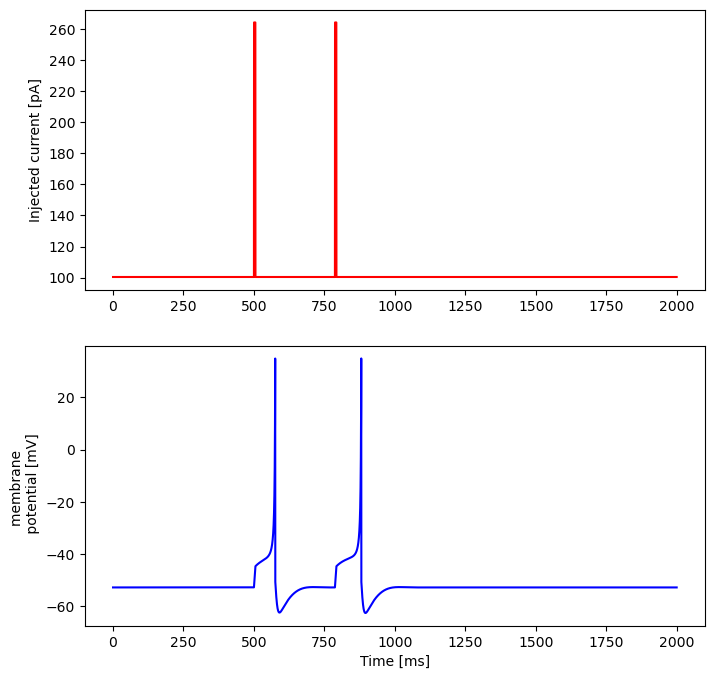

In [19]:
idx = 299

fig, ax = plot_potential_versus_injected(X[idx], T, I_inj[idx])
plt.show()

[6.87194767e+13 1.40845070e+03 7.04225352e+02 4.69483568e+02
 3.52112676e+02 2.81690141e+02 2.34741784e+02 2.01207243e+02
 1.76056338e+02 1.56739812e+02 1.41043724e+02 1.28205128e+02
 1.17508813e+02 1.08459870e+02 1.00704935e+02 9.39849624e+01
 8.81057269e+01 8.29875519e+01 7.83699060e+01 7.42390497e+01
 7.05218618e+01 6.71591672e+01 6.41025641e+01 6.13120785e+01
 5.87544066e+01 5.64334086e+01 5.42593597e+01 5.22466040e+01
 5.03778338e+01 4.86381323e+01 4.70145745e+01 4.54959054e+01
 4.40722785e+01 4.27350427e+01 4.14937759e+01 4.03063281e+01
 3.91849530e+01 3.81242852e+01 3.71195249e+01 3.61663653e+01
 3.52609309e+01 3.43997248e+01 3.35908633e+01 3.28083990e+01
 3.20615582e+01 3.13479624e+01 3.06654400e+01 3.00120048e+01
 2.93858360e+01 2.87852619e+01 2.82167043e+01 2.76625173e+01
 2.71296799e+01 2.66169816e+01 2.61233020e+01 2.56476019e+01
 2.51889169e+01 2.47463499e+01 2.43190661e+01 2.39120038e+01
 2.35128145e+01 2.31267345e+01 2.27531286e+01 2.23914017e+01
 2.20409963e+01 2.170138

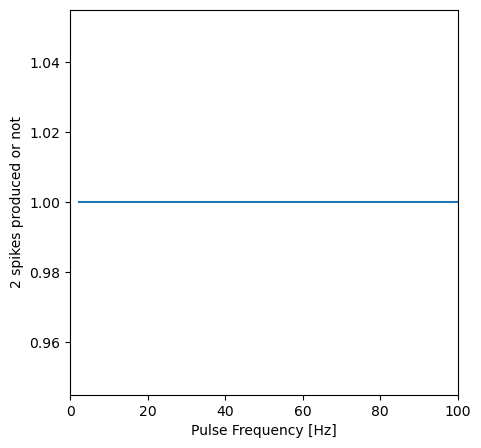

In [6]:
# generate plot of number of spikes versus pulse frequency
# Need to account for the fact there is a spike latency
# end of first pulse is at 500 ms + 5 ms (= delay + pulse_duration)
# resonance frequency is then ISI_pulse - (pulse2_start - spike_time)


pulse2_start = np.zeros(N_neurons)      # store the start of the 2nd pulse for each simulation
spike_boolean = np.zeros(N_neurons)

for n in range(N_neurons):
    if len(spikes[n, np.isnan(spikes[n])]) != 1:
        spike_boolean[n] = 1

    pulse_times = np.argwhere(I_inj[n, :] >= threshold+1)*dt
    pulse2_start[n] = pulse_times[np.where(pulse_times > pulse1_end)][0] 



InterPulse_Intervals = pulse2_start - pulse1_end                    # IPI for all sims

first_spike_time = pulse1_end + time_to_spike

resonant_ISI = pulse2_start - first_spike_time                      # time between first spike and second pulse
resonant_f = 1000/resonant_ISI                                      # corresponding resonance frequency

print(resonant_f)
print("- - - - - - -")
print(spike_boolean)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.plot(resonant_f, spike_boolean)
ax.set_xlabel("Pulse Frequency [Hz]")
ax.set_ylabel("2 spikes produced or not")
ax.set_xlim((0, 100))
freq_bands = get_resonance_bands(resonant_f, spike_boolean)
print(freq_bands)


#### Now test the multi-pulse protocol


In [7]:
# first enduce a spike and find the height of the second spike which induces a 

pulse_frequency = 20 # Hz
pulse_ISI = 1000/pulse_frequency # ms
pulse2_heights = np.linspace(100, 600, N_neurons)

# get the minimum height of the 2nd pulse.
pulse2_height = find_2nd_pulse_height(RS, pulse2_heights, threshold, x_ini, pulse_duration, pulse_height, time_to_spike, pulse_ISI) + 10
print(pulse2_height)

100%|██████████| 49999/49999 [00:15<00:00, 3180.62it/s]


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
## Now use this 2nd pulse height as the standard height for the multipulse train.
# will just apply a fixed number of pulses, see if the pulse after a spike
# also produces a spike. Or rewrite classes to have an exit clause.
multipulse_ISIs = np.linspace(5, 200, N_neurons)
multipulse_freq = 1000/multipulse_ISIs
N_pulses = 10
pulse_duration = 5  # ms
delay = 30         # ms
I_multi = np.array([spikes_constant(N_iter, dt, threshold, isi, N_pulses, pulse2_height, pulse_duration, delay) for isi in multipulse_ISIs])
print(np.shape(I_multi))
# re-initialise the neuron batch
batch.Initialise(x_start, t_start)

(600, 200000)


In [ ]:
# run the multipulse tests
X, T, spikes = batch.update_batch(dt, N_iter, I_multi)


 41%|████      | 82464/199999 [00:31<00:44, 2642.90it/s]


KeyboardInterrupt: 

In [ ]:
# Define pulse starts from the multipulse_ISIs
pulse_starts = np.array([[delay + i*(isi) for i in range(N_pulses)] for isi in multipulse_ISIs])
# pulse ends
pulse_ends = np.array([[delay + pulse_duration + i*(isi) for i in range(N_pulses)] for isi in multipulse_ISIs])


' THE STUPID WAY\n# get the times of the pulses.\npulse_bool = I_multi > threshold # store as a boolean, the indices where there is a pulse.\n#pulse_times = np.full(shape = (N_neurons, N_pulses*pulse_duration/dt), fill_value = T[pulse_bool])\nnum_pulse_indices = int(N_pulses*pulse_duration/dt)\npulse_times = np.zeros((N_neurons, num_pulse_indices))\ntimes = np.full((N_neurons, np.shape(T)[0]), T)\n\npulse_times = times[pulse_bool].reshape((N_neurons, num_pulse_indices), order = \'C\')\nprint(f"pulse times: {np.shape(pulse_times)}")\nprint(pulse_times[:num_pulse_indices])\n'

In [ ]:
## Testing extracting the pulse times


In [ ]:
spike_ISI = np.diff(spikes, axis = 1)
spike_freq = 1000/np.nanmean(spike_ISI, axis = 1)
spike_freq = np.nan_to_num(spike_freq, nan = 0.0)

num_spikes = np.zeros(N_neurons, dtype = int)

for i in range(N_neurons):
    print(spikes[i])
    print(spikes[i, ~np.isnan(spikes[i])])
    num_spikes[i] = len(spikes[i, ~np.isnan(spikes[i])])


print(num_spikes)

C:\Users\liamm\AppData\Local\Temp\ipykernel_9696\2479538924.py:2: RuntimeWarning: Mean of empty slice
  spike_freq = 1000/np.nanmean(spike_ISI, axis = 1)


[40.39   nan   nan   nan   nan   nan   nan   nan   nan]
[40.39]
[40.74   nan   nan   nan   nan   nan   nan   nan   nan]
[40.74]
[41.08   nan   nan   nan   nan   nan   nan   nan   nan]
[41.08]
[41.41   nan   nan   nan   nan   nan   nan   nan   nan]
[41.41]
[41.74   nan   nan   nan   nan   nan   nan   nan   nan]
[41.74]
[42.07   nan   nan   nan   nan   nan   nan   nan   nan]
[42.07]
[42.42   nan   nan   nan   nan   nan   nan   nan   nan]
[42.42]
[42.76   nan   nan   nan   nan   nan   nan   nan   nan]
[42.76]
[43.11   nan   nan   nan   nan   nan   nan   nan   nan]
[43.11]
[43.46   nan   nan   nan   nan   nan   nan   nan   nan]
[43.46]
[43.83   nan   nan   nan   nan   nan   nan   nan   nan]
[43.83]
[44.2  nan  nan  nan  nan  nan  nan  nan  nan]
[44.2]
[44.57   nan   nan   nan   nan   nan   nan   nan   nan]
[44.57]
[44.96   nan   nan   nan   nan   nan   nan   nan   nan]
[44.96]
[45.35   nan   nan   nan   nan   nan   nan   nan   nan]
[45.35]
[45.76   nan   nan   nan   nan   nan   nan   nan  

Number of pulses: 10
Pulse Frequency: 14.26
Number of spikes: 7
Firing Frequency: 14.277555682480145


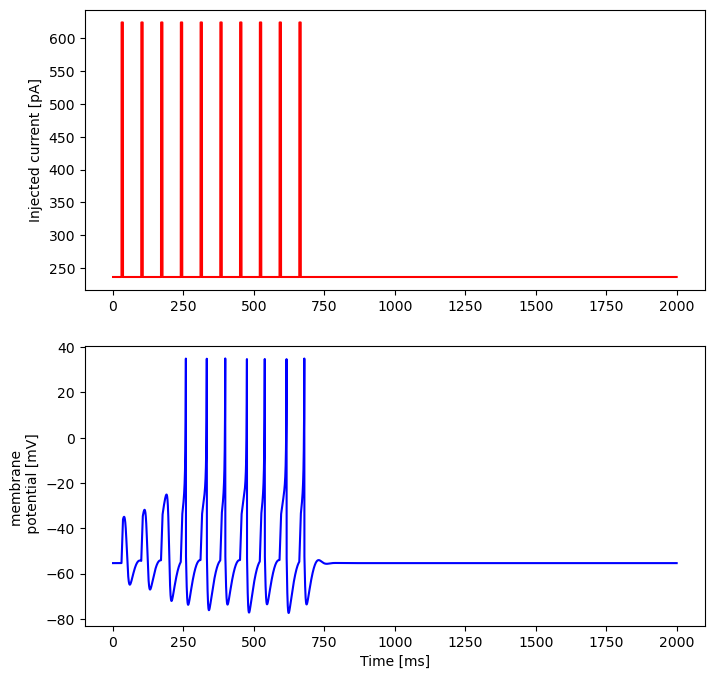

In [ ]:
idx = 200
print(f"Number of pulses: {N_pulses}")
print(f"Pulse Frequency: {np.round(multipulse_freq[idx], 2)}")
print(f"Number of spikes: {num_spikes[idx]}")
print(f"Firing Frequency: {spike_freq[idx]}")

fig, ax = plot_potential_versus_injected(X[idx, :], T, I_multi[idx, :])# , split)

plt.show()

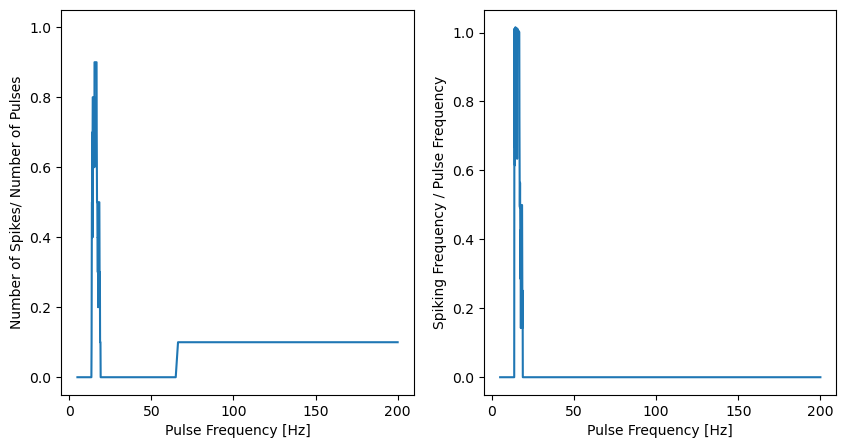

In [ ]:
freq_ratio = spike_freq/multipulse_freq
spike_ratio = num_spikes/N_pulses

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(multipulse_freq, spike_ratio)
ax[0].set(ylabel = "Number of Spikes/ Number of Pulses", xlabel = "Pulse Frequency [Hz]")
xmin = np.min(pulse_frequency)
xmax = np.max(pulse_frequency)
ax[0].hlines(y = 1, xmin = xmin, xmax = xmax, colors = "gray", linestyle = 'dashed')
#ax[0].set_xscale('log')

ax[1].plot(multipulse_freq, freq_ratio)
ax[1].hlines(y = 1, xmin = xmin, xmax = xmax, colors = "gray", linestyle = 'dashed')
#ax[1].set_xscale('log')
ax[1].set(ylabel = "Spiking Frequency / Pulse Frequency", xlabel = "Pulse Frequency [Hz]")

plt.show()

In [ ]:
### Testing with spike and pulse times.
print(np.shape(pulse_times))
pulse_start = pulse_times[np.where(np.diff(pulse_times, axis = 1) > dt)]
print(pulse_start)

(1000, 1)
[]
